In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# # Display the result
# cv2.imshow('Result', result)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [2]:
currentpath = os.getcwd()
def precision_score_(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_pred = np.sum(pred_mask)
    precision = np.mean(intersect/total_pixel_pred)
    return round(precision, 3)

def recall_score_(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_truth = np.sum(groundtruth_mask)
    recall = np.mean(intersect/total_pixel_truth)
    return round(recall, 3)

def imshow(img):
    plt.imshow(img)
    plt.show()

def reportGen(info,img_path,data,data1):
    img_list =img_path[0]
    img_list=os.listdir(img_list)
    precision_p=np.sum(data)/len(img_list)
    recall_p=np.sum(data1)/len(img_list)
    html_string='<html><head> <style>table, th, td {border: 1px solid black;border-collapse: collapse;}</style><title></title></head><body>'
    html_string +="<h1>HardExudate Report</h1>"
    html_string +="<h2>Precision: "+  str(round(precision_p,3)) +"</h2>"
    html_string +="<h2>Recall: "+  str(round(recall_p,3)) +"</h2>"
    html_string +="<table><tr>"
    for head in range(0,len(info)):
        html_string +="<th width='40%'>"+ info[head] +"</th>"
    html_string +="</tr>"
   
    for sl in range(0, len(img_list)):
        html_string +="<tr>"
        for path in range(0, len(img_path)):
            ld=os.listdir(img_path[path])
            html_string +="<td>"+ ld[sl] +"<br/><img width='350' src='"+ img_path[path] + ld[sl] +"'></td>"

        html_string +="<td>"+ str(data[sl]) +"</td>"
        html_string +="<td>"+ str(data1[sl]) +"</td>"
        html_string +="</tr>"

    html_string +='</table></body></html>'
    f = open('Results/_report.html','w')
    f.write(html_string)
    f.close()

In [3]:
image_path = "data/images/training/"
Precisions=[]
Recalls=[]
imgList=os.listdir(image_path)
results=[]
total_precision=0
for ins in range(1,len(imgList)+1):
    number="%02d" % (ins,)
    image_id="IDRiD_"+str(number)+".jpg"
    
    # Load the retinal image
    img = cv2.imread(image_path+image_id)

    # Convert the image to grayscale
    img_resized = cv2.resize(img,None,fx=0.60,fy=0.60)
    (B, G, R) = cv2.split(img_resized)
    ye = cv2.addWeighted(R,0.73925,G,0.14675,0)
    ye = cv2.addWeighted(ye,1,B,0.114,0)
    (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(ye)
    cv2.circle(img_resized,maxLoc,250,(0,0,0), -1)

    cv2.imwrite(os.path.join('Results/OpticalDisk/Training/'+image_id),img_resized)
    # Apply a median blur to reduce noise
    # gray = cv2.medianBlur(gray, 5)

    gray=cv2.cvtColor(img_resized,cv2.COLOR_RGB2GRAY)

    clahe = cv2.createCLAHE(clipLimit = 3)
    final_img = clahe.apply(gray)

    # imageholder = cv2.fastNlMeansDenoisingColored(final_img,None,10,10,21,7)
    
    cv2.imwrite(os.path.join('Results/Prepos/Training/'+image_id),final_img)
    # Threshold the image to create a binary mask
    ret, thresh = cv2.threshold(final_img, 120, 255, cv2.THRESH_BINARY)
    
    # Create a structuring element for morphology operations
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))

    # Apply morphological operations to fill holes and smooth the image
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)

    # Find contours in the binary image
    contours, hierarchy = cv2.findContours(opened, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Create a blank mask for the hard exudates
    mask = np.zeros_like(img[:,:,0])

    # Loop through each contour and draw it on the mask
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 50 and area < 10000:
            cv2.drawContours(mask, [contour], -1, (255,255,255), -1)

    # Apply the mask to the original image
    results = cv2.bitwise_and(img, img, mask=mask)
    cv2.imwrite(os.path.join('Results/HardExodus/Training/'+image_id),mask)

    img_groundtruths=cv2.imread("data/groundtruths/training/hard exudates/IDRiD_"+str(number)+"_EX.tif",cv2.IMREAD_COLOR)
    precision = precision_score_(img_groundtruths,results)
    recall = recall_score_(img_groundtruths,results)
    Precisions.append(precision)
    Recalls.append(recall)

tablehead=[
    'Original Image',
    # 'OpticalDisk',
    'PreProcess',
    'Hard Exudate',
    'Precision',
    'Recall']

original_img=os.path.join(currentpath,'data','images','Training')+'/'
# opticaldisk=os.path.join(currentpath,'Results','OpticalDisk','Training')+'/'
preprocess=os.path.join(currentpath,'Results','Prepos','Training')+'/'
hardexudate=os.path.join(currentpath,'Results','HardExodus','Training')+'/'
filepath=[original_img,preprocess, hardexudate]
reportGen(tablehead,filepath,Precisions,Recalls)


In [4]:
print(total_precision/len(imgList))

0.0


110.59544006638684


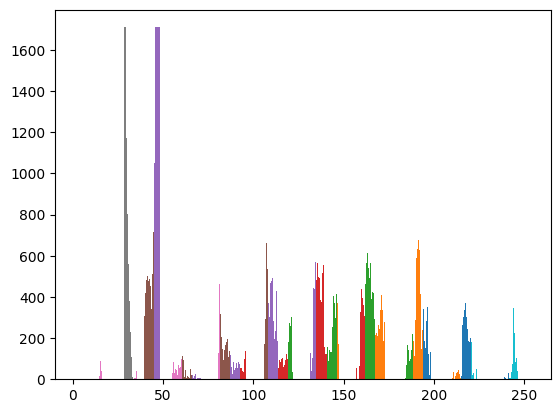

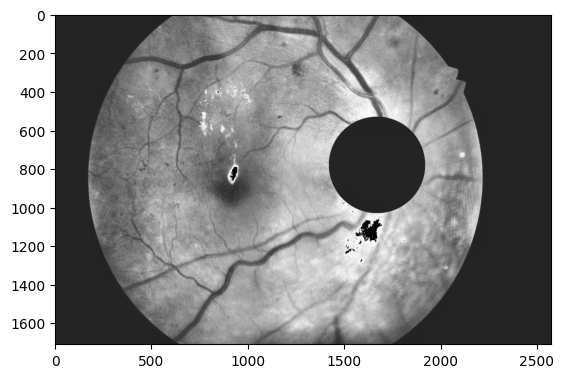

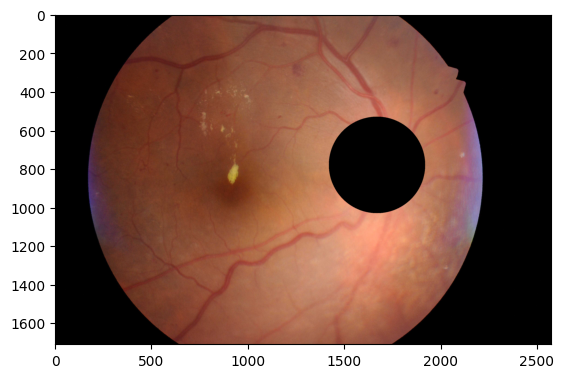

In [5]:
image_path = "data/images/training/"
image_id="IDRiD_06.jpg"
img=cv2.imread(image_path+image_id)
img_resized = cv2.resize(img,None,fx=0.60,fy=0.60)
(B, G, R) = cv2.split(img_resized)
ye = cv2.addWeighted(R,0.73925,G,0.14675,0)
ye = cv2.addWeighted(ye,1,B,0.114,0)
(minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(ye)
cv2.circle(img_resized,maxLoc,250,(0,0,0), -1)

img=cv2.cvtColor(img_resized,cv2.COLOR_BGR2RGB)
gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
# plt.hist(gray)

clahe = cv2.createCLAHE(clipLimit = 5)
final_img = clahe.apply(gray) + 30

print(np.mean(final_img))
plt.hist(final_img)
# plt.plot(eqhist)
plt.show()
imshow(cv2.cvtColor(final_img,cv2.COLOR_BGR2RGB))
imshow(img)